In [1]:
#export
"""
For operations that feel like the termination of operations
"""
from collections import defaultdict
from typing import Iterator, Any
from k1lib.cli.init import BaseCli
import numbers, numpy as np, k1lib, tempfile, os, sys, time, math
from k1lib import cli; from k1lib.cli.typehint import *
import matplotlib.pyplot as plt
try: import torch; hasTorch = True
except: hasTorch = False
__all__ = ["stdout", "tee", "file", "pretty", "display", "headOut",
           "intercept", "plotImgs"]
settings = k1lib.settings.cli

In [2]:
#export
class stdout(BaseCli):
    def __init__(self):
        """Prints out all lines. If not iterable, then print out the input
raw. Example::

    # prints out "0\\n1\\n2"
    range(3) | stdout()
    # same as above, but (maybe?) more familiar
    range(3) > stdout()

This is rarely used alone. It's more common to use :meth:`headOut`
for list of items, and :meth:`display` for tables."""
        super().__init__()
    def _typehint(self, inp): return None
    def __ror__(self, it:Iterator[str]):
        try:
            it = iter(it)
            for line in it: print(line)
        except TypeError: print(it)

In [3]:
with k1lib.captureStdout() as out:
    range(3) > stdout()
assert out() == ['0', '1', '2', '']

In [4]:
#export
_defaultTeeF = lambda s: f"{s}\n"
class tee(BaseCli):
    def __init__(self, f=_defaultTeeF, s=None, every:int=1, delay:float=0):
        """Like the Linux ``tee`` command, this prints the elements to another
specified stream, while yielding the elements. Example::

    # prints "0\\n1\\n2\\n3\\n4\\n" and returns [0, 1, 4, 9, 16]
    range(5) | tee() | apply(op() ** 2) | deref()

See also: :class:`~k1lib.cli.modifier.consume`

This cli is not exactly well-thoughout and is a little janky

:param f: element transform function. Defaults to just adding a new
    line at the end
:param s: stream to write to. Defaults to :attr:`sys.stdout`
:param every: only prints out 1 line in ``every`` lines, to limit print rate
:param delay: if subsequent prints are less than this number of seconds apart then don't print them"""
        self.s = s or sys.stdout; self.f = f; self.every = every; self.delay = delay
    def __ror__(self, it):
        s = self.s; f = self.f; every = self.every; delay = self.delay
        lastTime = 0
        for i, e in enumerate(it):
            if i % every == 0 and time.time()-lastTime > delay:
                print(f(e), end="", file=s); lastTime = time.time()
            yield e
    def cr(self):
        """Tee, but replaces the previous line. "cr" stands for carriage return.
Example::

    # prints "4" and returns [0, 1, 4, 9, 16]. Does print all the numbers in the middle, but is overriden
    range(5) | tee().cr() | apply(op() ** 2) | deref()"""
        f = (lambda x: x) if self.f == _defaultTeeF else self.f
        self.f = lambda s: f"\r{f(s)}"; return self
    def crt(self):
        """Like :meth:`tee.cr`, but includes an elapsed time text at the end.
Example::

    range(5) | tee().cr() | apply(op() ** 2) | deref()"""
        beginTime = time.time()
        f = (lambda x: x) if self.f == _defaultTeeF else self.f
        self.f = lambda s: f"\r{f(s)}, {int(time.time() - beginTime)}s elapsed"; return self
    def autoInc(self):
        """Like :meth:`tee.crt`, but instead of printing the object, just print
the current index and time"""
        beginTime = time.time(); autoInc = k1lib.AutoIncrement()
        self.f = lambda s: f"\r{autoInc()}, {int(time.time()-beginTime)}s elapsed"; return self

In [5]:
with k1lib.captureStdout() as out:
    assert range(5) | tee() | cli.apply(cli.op() ** 2) | cli.deref() == [0, 1, 4, 9, 16]
assert out() == ['0', '1', '2', '3', '4', '']
with k1lib.captureStdout() as out:
    assert range(5) | tee().cr() | cli.apply(cli.op() ** 2) | cli.deref() == [0, 1, 4, 9, 16]
assert out() == ['4']
assert range(5) | tee().crt() | cli.deref() == [0, 1, 2, 3, 4]

4, 0s elapsed

In [6]:
#export
try:
    import PIL; hasPIL = True
except: hasPIL = False
class file(BaseCli):
    def __init__(self, fileName:str=None, flush:bool=False, mkdir:bool=False):
        """Opens a new file for writing. This will iterate through
the iterator fed to it and put each element on a separate line. Example::

    # writes "0\\n1\\n2\\n" to file
    range(3) | file("test/f.txt")
    # same as above, but (maybe?) more familiar
    range(3) > file("text/f.txt")
    # returns ['0', '1', '2']
    cat("folder/f.txt") | deref()

If the input is a string, then it will just put the string into the
file and does not iterate through the string::

    # writes "some text\\n123" to file, default iterator mode like above
    ["some text", "123"] | file("test/f.txt")
    # same as above, but this is a special case when it detects you're piping in a string
    "some text\\n123" | file("test/f.txt")

If the input is a :class:`bytes` object or an iterator of :class:`bytes`, then it
will open the file in binary mode and dumps the bytes in::

    # writes bytes to file
    b'5643' | file("test/a.bin")
    [b'56', b'43'] >> file("test/a.bin")
    # returns ['56435643']
    cat("test/a.bin") | deref()

If the input is a :class:`PIL.Image.Image` object, then it will just save the image in
the file::

    # creates an random image and saves it to a file
    torch.randn(100, 200) | toImg() | file("a.png")

Reminder that the image pixel range is expected to be from 0 to 255. You
can create temporary files on the fly by not specifying a file name::

    # creates temporary file
    url = range(3) > file()
    # returns ['0', '1', '2']
    cat(url) | deref()

This can be especially useful when integrating with shell scripts that wants to
read in a file::

    seq1 = "CCAAACCCCCCCTCCCCCGCTTC"
    seq2 = "CCAAACCCCCCCCTCCCCCCGCTTC"
    # use "needle" program to locally align 2 sequences
    None | cmd(f"needle {seq1 > file()} {seq2 > file()} -filter")

You can also append to file with the ">>" operator::

    url = range(3) > file()
    # appended to file
    range(10, 13) >> file(url)
    # returns ['0', '1', '2', '10', '11', '12']
    cat(url) | deref()

:param fileName: if not specified, create new temporary file and returns the url
    when pipes into it
:param flush: whether to flush to file immediately after every iteration
:param mkdir: whether to recursively make directories going to the file location or not"""
        super().__init__(); self.fileName = fileName; self.flush = flush; self.mkdir = mkdir
        self.append = False # whether to append to file rather than erasing it
    def __ror__(self, it:Iterator[str]) -> None:
        super().__ror__(it); fileName = self.fileName; flushF = (lambda f: f.flush()) if self.flush else (lambda _: 0)
        if fileName is None:
            f = tempfile.NamedTemporaryFile()
            fileName = f.name; f.close()
        fileName = os.path.expanduser(fileName); firstLine = None
        if self.mkdir: os.makedirs(os.path.dirname(fileName), exist_ok=True)
        if hasPIL and isinstance(it, PIL.Image.Image): it.save(fileName); return fileName
        if isinstance(it, str): it = [it]; text = True
        elif isinstance(it, bytes): text = False
        else:
            it = iter(it); sentinel = object(); firstLine = next(it, sentinel)
            if firstLine is sentinel: # no elements at all
                with open(fileName, "w") as f: f.write("")
                return fileName
            text = not isinstance(firstLine, bytes)
        if text:
            with open(fileName, "a" if self.append else "w") as f:
                if firstLine is not None: f.write(f"{firstLine}\n")
                for line in it: f.write(f"{line}\n"); flushF(f)
        else:
            with open(fileName, "ab" if self.append else "wb") as f:
                if firstLine is not None:
                    f.write(firstLine)
                    for e in it: f.write(e); flushF(f)
                else: f.write(it)
        return fileName
    def __rrshift__(self, it):
        self.append = True # why do this? because `a | b >> c` will be interpreted as `a | (b >> c)`
        if isinstance(it, BaseCli): return cli.serial(it, self)
        else: return self.__ror__(it)
    @property
    def name(self):
        """File name of this :class:`file`"""
        return self.fileName

In [7]:
range(3) > file("test/f.txt")
assert cli.cat("test/f.txt") | cli.deref() == ['0', '1', '2']
b'5643' | file("test/a.bin")
[b'56', b'43'] | cli.apply(cli.iden()) >> file("test/a.bin")
assert cli.cat("test/a.bin") | cli.deref() == ['56435643']
url = range(3) > file()
assert cli.cat(url) | cli.deref() == ['0', '1', '2']
url = range(3) > file(); range(10, 13) >> file(url, True)
assert cli.cat(url) | cli.deref() == ['0', '1', '2', '10', '11', '12']

In [27]:
#export
class pretty(BaseCli):
    def __init__(self, delim=""):
        """Pretty-formats a table, or a list of tables.
Example::

    # These 2 statements are pretty much the same
    [range(10), range(10, 20)] | head(5) | pretty() > stdout()
    [range(10), range(10, 20)] | display()

They both print::

    0    1    2    3    4    5    6    7    8    9    
    10   11   12   13   14   15   16   17   18   19   

This can also pretty-formats multiple tables::

    [[range(10), range(10, 20)], [["abc", "defff"], ["1", "1234567"]]] | ~pretty() | joinStreams() | stdout()

This will print::

    0     1         2    3    4    5    6    7    8    9    
    10    11        12   13   14   15   16   17   18   19   
    abc   defff     
    1     1234567   

:param delim: delimiter between elements within a row. You might want
    to set it to "|" to create an artificial border or sth
"""
        self.delim = delim; self.inverted = False
    def _typehint(self, inp): return tIter(str)
    def __ror__(self, it) -> Iterator[str]:
        inv = self.inverted; delim = self.delim
        if inv: tables = [[list(i1) for i1 in i2] for i2 in it]
        else: tables = [[list(i1) for i1 in it]]
        widths = defaultdict(lambda: 0)
        for table in tables:
            for row in table:
                for i, e in enumerate(row):
                    e = f"{e}"; row[i] = e
                    widths[i] = max(len(e), widths[i])
        def gen(table):
            for row in table:
                yield delim.join(e.rstrip(" ").ljust(w+3) for w, e in zip(widths.values(), row))
        if inv: return tables | cli.apply(gen)
        else: return gen(tables[0])
    def __invert__(self): self.inverted = not self.inverted; return self
def display(lines:int=10):
    """Convenience method for displaying a table.
Pretty much equivalent to ``head() | pretty() | stdout()``.

See also: :class:`pretty`"""
    f = pretty() | stdout()
    if lines is None: return f
    else: return cli.head(lines) | f
def headOut(lines:int=10):
    """Convenience method for head() | stdout()"""
    if lines is None: return stdout()
    else: return cli.head(lines) | stdout()

In [32]:
with k1lib.captureStdout() as out1: [range(10), range(10)] | cli.head(5) | pretty() > stdout()
with k1lib.captureStdout() as out2: [range(10), range(10)] | display();
assert out1() == out2()
with k1lib.captureStdout() as out: [[range(10), range(10, 20)], [["abc", "defff"], ["1", "1234567"]]] | ~pretty() | cli.joinStreams() | stdout()
assert len(out()) == 5

In [10]:
#export
def tab(text, pad="    "):
    return "\n".join([pad + line for line in text.split("\n")])
class intercept(BaseCli):
    def __init__(self, f=None, raiseError:bool=True):
        """Intercept flow at a particular point, analyze the object piped in, and
raises error to stop flow. Example::

    3 | intercept()

:param f: prints out the object transformed by this function
:param raiseError: whether to raise error when executed or not."""
        self.f = f or cli.shape(); self.raiseError = raiseError
    def __ror__(self, s):
        print(type(s)); print(self.f(s))
        if self.raiseError: raise RuntimeError("intercepted")
        return s

In [12]:
try: 3 | intercept(cli.iden()); assert False
except: pass

<class 'int'>
3


In [16]:
#export
class plotImgs(BaseCli):
    def __init__(self, col=5, aspect=1, fac=2, axis=False, table=False, im=False):
        """Plots a bunch of images at the same time in a table.
Example::

    # plots all images
    [torch.randn(10, 20), torch.randn(20, 10)] | plotImgs()
    # plots all images with titles
    [[torch.randn(10, 20), "img 1"], [torch.randn(20, 10), "img 2"]] | plotImgs()

If you have multiple rows with different number of images, you can
plot that with this too, just set ``table=True`` like this::

    [[torch.randn(10, 20), torch.randn(20, 10)], [torch.randn(10, 20)]] | plotImgs(table=True)

There's another cli that kinda does what this does: :class:`~k1lib.cli.utils.sketch`. You have
more control over there, and it does roughly what this cli does, but the typical usage is
different. This is more for plotting static, throwaway list of 2d arrays, like training set
images, where as :class:`~k1lib.cli.utils.sketch` is more about plotting results of detailed
analyses.

:param col: number of columns in the table. If explicitly None, it will turn
    into the number of images fed. Not available if ``table=True``
:param aspect: aspect ratio of each images, or ratio between width and height
:param fac: figsize factor. The higher, the more resolution
:param axis: whether to display the axis or not
:param table: whether to plot using table mode
:param im: if True, returns an image"""
        self.col = col; self.fac = fac; self.axis = axis; self.aspect = aspect; self.table = table; self.im = im
    def __ror__(self, imgs):
        imgs = imgs | cli.deref(); col = self.col; fac = self.fac; aspect = self.aspect**0.5
        if not self.table: # main code
            if len(imgs) == 0: return
            if col is None or col > len(imgs): col = len(imgs)
            n = math.ceil(len(imgs)/col)
            fig, axes = plt.subplots(n, col, figsize=(col*fac*aspect, n*fac/aspect));
            axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
            for ax, im in zip(axes, imgs):
                plt.sca(ax)
                if isinstance(im, list): plt.imshow(im[0]); plt.title(im[1])
                else: plt.imshow(im)
                if not self.axis: ax.axis("off")
            for i in range(len(imgs), len(axes)): axes[i].remove() # removing leftover axes
        else:
            if col != 5: raise Exception("Currently in table mode, can't set `col` parameter") # change this value to match col's default value
            h = imgs | cli.shape(0); w = imgs | cli.shape(0).all() | cli.toMax()
            fig, axes = plt.subplots(h, w, figsize=(w*fac*aspect, h*fac/aspect));
            for rAx, rIm in zip(axes, imgs):
                for cAx, cIm in zip(rAx, rIm):
                    plt.sca(cAx)
                    if isinstance(cIm, list): plt.imshow(cIm[0]); plt.title(cIm[1])
                    else: plt.imshow(cIm)
                    if not self.axis: cAx.axis("off")
                for i in range(len(rIm), len(rAx)): rAx[i].remove() # removing leftover axes
        plt.tight_layout()
        if self.im: return plt.gcf() | cli.toImg()

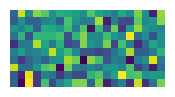

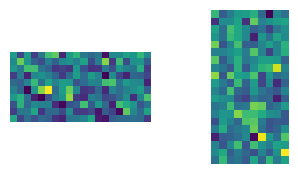

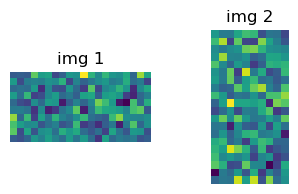

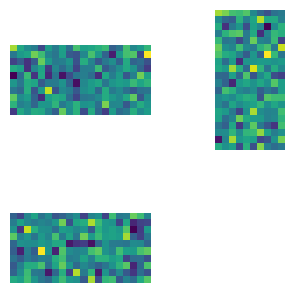

In [18]:
[torch.randn(10, 20)] | plotImgs()
[torch.randn(10, 20), torch.randn(20, 10)] | plotImgs()
[[torch.randn(10, 20), "img 1"], [torch.randn(20, 10), "img 2"]] | plotImgs()
[[torch.randn(10, 20), torch.randn(20, 10)], [torch.randn(10, 20)]] | plotImgs(table=True)

In [34]:
!../../export.py cli/output

2023-07-05 16:38:20,853	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.133:6379...
2023-07-05 16:38:20,857	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
6698    1   39%   
10328   0   61%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.2
Uninstalling k1lib-1.4.2:
  Successfully uninstalled k1lib-1.4.2
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
wr